In [3]:
from docplex.mp.model import Model
import numpy as np
import random
import itertools
import numpy as np
import itertools
import random
import networkx as nx
from concurrent.futures import ThreadPoolExecutor
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit import QuantumCircuit,  transpile, ClassicalRegister
from qiskit.circuit import ParameterVector, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.primitives import BackendSamplerV2, Sampler
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
import copy
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

In [15]:
n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [7]:
def graph_to_qubo(graph):
    nodes = graph.node_indexes()  # Get node indices
    num_nodes = len(nodes)

    # Create a mapping from node labels to indices
    node_index = {node: i for i, node in enumerate(nodes)}

    # Initialize QUBO matrix
    Q = np.zeros((num_nodes, num_nodes))

    # Assign edge weights (-1) and ensure symmetry
    for u, v in graph.edge_list():
        i, j = node_index[u], node_index[v]  # Convert node labels to indices
        Q[i, j] = -1  # Interaction term
        Q[j, i] = -1  # Symmetric

    return Q
Q = graph_to_qubo(graph)

In [49]:
min_ = 1000
for i in range(2**n):
    x = [ii for ii in np.binary_repr(i,n)]
    # print(x)
    x = np.array([int(ii) for ii in x])
    if x.T @ Q @ x < min_:
        min_ = min(x.T @ Q @ x, min_)
        x_opt = x
print(min_,x_opt)

-12.0 [1 1 1 1 1]


In [13]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

ising_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", ising_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [15]:
cost_hamiltonian = ising_hamiltonian

In [19]:
num_qubits = n
mixer_hamiltonian = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(num_qubits)],
    num_qubits=num_qubits
)

In [21]:
mixer_hamiltonian = SparsePauliOp.from_sparse_list(
    [("X", [i], 1.0) for i in range(num_qubits)] +  # Single-qubit X terms
    [("XX", [i, i+1], 1.0) for i in range(num_qubits - 1)],  # Two-qubit XX terms
    num_qubits=num_qubits
)

In [23]:
mixer_hamiltonian

SparsePauliOp(['IIIIX', 'IIIXI', 'IIXII', 'IXIII', 'XIIII', 'IIIXX', 'IIXXI', 'IXXII', 'XXIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In [25]:
p = 4
gamma = ParameterVector('γ', p)
beta = ParameterVector('β', p)

In [27]:
gamma  = np.random.uniform(0, np.pi/4, p)
beta = np.random.uniform(0, np.pi/4, p)
def qaoa_circuit(gamma, beta):
    qc = QuantumCircuit(num_qubits)
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    
    for i in range(p):
        # Cost Hamiltonian evolution
        cost_evolution = PauliEvolutionGate(cost_hamiltonian, time=gamma[i])
        qc.append(cost_evolution, range(num_qubits))
        
        # Mixer Hamiltonian evolution
        mixer_evolution = PauliEvolutionGate(mixer_hamiltonian, time=beta[i])
        qc.append(mixer_evolution, range(num_qubits))
    
    # Add a Classical Register with 'num_qubits' bits
    cr = ClassicalRegister(num_qubits)
    qc.add_register(cr)
    #qc.h(range(num_qubits))
    # Measure all qubits and store the results in the classical register
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

In [29]:
qc = qaoa_circuit(gamma, beta)
print(qc)

      ┌───┐»
 q_0: ┤ H ├»
      ├───┤»
 q_1: ┤ H ├»
      ├───┤»
 q_2: ┤ H ├»
      ├───┤»
 q_3: ┤ H ├»
      ├───┤»
 q_4: ┤ H ├»
      └───┘»
c0: 5/═════»
           »
«      ┌────────────────────────────────────────────────────────────────────┐»
« q_0: ┤0                                                                   ├»
«      │                                                                    │»
« q_1: ┤1                                                                   ├»
«      │                                                                    │»
« q_2: ┤2 exp(-it (IIIZZ + IIZIZ + ZIIIZ + IIZZI + IZZII + ZZIII))(0.17394) ├»
«      │                                                                    │»
« q_3: ┤3                                                                   ├»
«      │                                                                    │»
« q_4: ┤4                                                                   ├»
«      └─────────────────────────────────

In [31]:
def objective_function(params):
    backend = AerSimulator() 
    sampler = BackendSamplerV2(backend=backend)
    transpiled_circuit = transpile(qc, backend)
    job = sampler.run([transpiled_circuit])
    result = job.result()
    pub_result = result[0]
    data_bin = pub_result.data
    bitstring_key = list(data_bin.keys())[0]
    bit_array = data_bin[bitstring_key] #c0 for Aersimulator
    counts = bit_array.get_counts()
    total_shots = sum(counts.values())  # Total number of measurements
    probabilities = {bitstring: count / total_shots for bitstring, count in counts.items()}
    expectation_value = 0
    for pauli, coeff in zip(cost_hamiltonian.paulis, cost_hamiltonian.coeffs):
        term_expectation = 0
        for bitstring, probability in probabilities.items():
            # Determine the eigenvalue of the Pauli term for the given bitstring
            eigenvalue = 1
            for qubit, pauli_char in enumerate(reversed(pauli.to_label())):
                if pauli_char == 'Z' and bitstring[qubit] == '1':
                    eigenvalue *= -1
                elif pauli_char == 'X' or pauli_char == 'Y':
                    raise ValueError("Non-Z Pauli operators require a basis change before measurement.")
            term_expectation += eigenvalue * probability
        expectation_value += coeff * term_expectation
    return np.real(expectation_value)

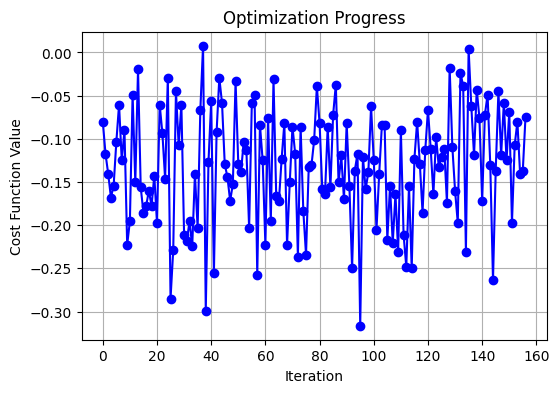

Optimized Parameters: [ 1.77226824 -0.15975965  1.78879849  0.63557198  0.82893951  0.02965849
  0.92502206 -0.47781645]
Optimization success: True


In [33]:
initial_params = np.random.uniform(0, np.pi/2, 2 * p)
cost_history = []

# Store cost function values
cost_history = []

# Callback function to store cost values (no real-time plotting)
def callback(x):
    cost = objective_function(x)
    cost_history.append(cost)

# Run optimization
result = minimize(objective_function, initial_params, method='COBYLA',
                  options={'maxiter': 1000, 'tol': 1e-10}, callback=callback)

# Plot results after optimization finishes
plt.figure(figsize=(6, 4))
plt.plot((cost_history), marker='o', linestyle='-', color='b')
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("Optimization Progress")
plt.grid()
plt.show()

# Print final result
print("Optimized Parameters:", result.x)
optimal_params = result.x
print("Optimization success:", result.success)

In [35]:
def optimal_state(params):
    backend = AerSimulator(seed_simulator = 42) 
    sampler = BackendSamplerV2(backend=backend)
    transpiled_circuit = transpile(qc, backend)
    job = sampler.run([transpiled_circuit])
    result = job.result()
    pub_result = result[0]
    data_bin = pub_result.data
    data_bin = pub_result.data
    bitstring_key = list(data_bin.keys())[0]
    bit_array = data_bin[bitstring_key]
    counts = bit_array.get_counts()
    ground_state = max(counts, key=counts.get)
    ground_state_list = [int(bit) for bit in ground_state]
    counts = bit_array.get_counts()
    total_shots = sum(counts.values())
    probabilities = {bitstring: count / total_shots for bitstring, count in counts.items()}
    expectation_value = 0
    for pauli, coeff in zip(cost_hamiltonian.paulis, cost_hamiltonian.coeffs):
        term_expectation = 0
        for bitstring, probability in probabilities.items():
            # Determine the eigenvalue of the Pauli term for the given bitstring
            eigenvalue = 1
            for qubit, pauli_char in enumerate(reversed(pauli.to_label())):
                if pauli_char == 'Z' and bitstring[qubit] == '1':
                    eigenvalue *= -1
                elif pauli_char == 'X' or pauli_char == 'Y':
                    raise ValueError("Non-Z Pauli operators require a basis change before measurement.")
            term_expectation += eigenvalue * probability
        expectation_value += coeff * term_expectation
    return ground_state_list, np.real(expectation_value)

final_result = optimal_state(optimal_params)
print('optimal_state', final_result[0], 'energy', final_result[1])

optimal_state [0, 1, 1, 1, 1] energy -0.224609375


In [53]:
x_opt, value

(array([1, 1, 1, 1, 1]), -12.0)

In [55]:
if (x_opt == final_result[0]).all():
    print("Both solutions are the same and correct.")
else:
    print("Solutions are different.")

Solutions are different.
